<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/fourier_cropping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* Demonstrate Fourier filtering

In [27]:
import numpy as np
import matplotlib.pyplot as plt
def doplt(arr): return(plt.imshow(arr,cmap='gray'))

The fastest library for doing Fourier transforms is fftw

In [3]:
!pip install pyfftw

     |████████████████████████████████| 2.6MB 5.7MB/s 


My own Fourier code

In [174]:
!rm fourier.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/fourier.py
import fourier

--2021-04-17 01:52:50--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/fourier.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2659 (2.6K) [text/plain]
Saving to: ‘fourier.py’

fourier.py          100%[===================>]   2.60K  --.-KB/s    in 0s      

2021-04-17 01:52:51 (26.1 MB/s) - ‘fourier.py’ saved [2659/2659]



`coords` wraps `np.meshgrid` and `coords.coords_n_by_d` gives back the cartesean coordinates of a pixel/voxel.

In [4]:
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
import coords

--2021-04-16 23:06:22--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2483 (2.4K) [text/plain]
Saving to: ‘coords.py’

coords.py           100%[===================>]   2.42K  --.-KB/s    in 0s      

2021-04-16 23:06:22 (46.4 MB/s) - ‘coords.py’ saved [2483/2483]



In [192]:
N=128
grid_1d = np.arange(-N//2,N//2)
xyz = coords.coords_n_by_d(grid_1d,d=3)

(3, 100)

Now let's make a random point cloud

In [ ]:
np.random.seed(4)
pad = 0.2*N
n_atoms = 100
atoms = np.random.uniform(low=-N//2+pad,high=N//2-pad,size=n_atoms*3).reshape(3,n_atoms)
atoms.shape

And sample that point cloud on the 3D grid (2D projection shown)

In [ ]:
def gauss(atoms,xv,yv,zv,sigma):
  x, y, z = atoms[0,:], atoms[1,:], atoms[2,:]
  r2 = (xv.reshape(-1,N,N,N)-x.reshape(-1,1,1,1))**2
  r2 += (yv.reshape(-1,N,N,N)-y.reshape(-1,1,1,1))**2
  r2 += (zv.reshape(-1,N,N,N)-z.reshape(-1,1,1,1))**2
  a = -0.5/sigma**2
  g = np.exp(a*r2).sum(0)
  return(g)
xv,yv,zv = np.meshgrid(grid_1d,grid_1d,grid_1d)



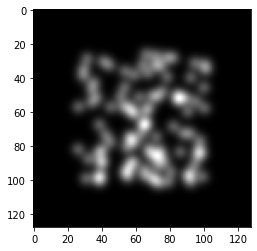

In [200]:
g = gauss(atoms,xv,yv,zv,sigma=3)
doplt(g.sum(-1))

I wrote some code to do Fourier transforms that are centred at the origin. They are based on the convention where the real space pixels are from [-N/2, -N/2+1,..., -1, 0, +1, +2, ..., N-2, N-1], which has length N. This "centres" things, where the first half is from [-N/2, ...,  -1], and the second half is from [0, ..., N-1]. In Fourier space, this makes the "DC" pixel be the first one in the second half.

In general because of the way the fast fourier transform factorizes / is recursive, it's fast when there is a prime factorization of the number of pixels (so not a large prime number). It can be faster to pad to a factor of $2^n$, for instance if we have 127 to pad to 128. Or to pad 109 or 113 to 128.

The Fourier transform of the full sized 3D volume only needs to be computed once. Then it can be stored, and filtered versions (at better and better resolution) can be computed as needed with the inverse Fourier transform.

In [201]:
g_f = fourier.do_fft(g,d=3)

For example if we want to have half the resolution we can "Fourier crop" by only transforming back half the pixels (centering at the origin properly).

In [206]:
N_crop = N//2
g_crop = fourier.do_ifft(g_f[s:e,s:e,s:e])

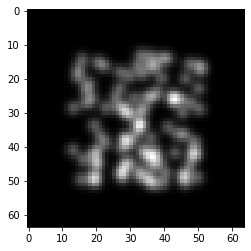

In [207]:
doplt(g_crop.sum(-1))

The above result would be the same as doing real space pooling. However if we want to do this at different resolutions, we would have to recompute things again and again. Instead, we can just crop the precomputed Fourier volume at different levels and take the iFFT.

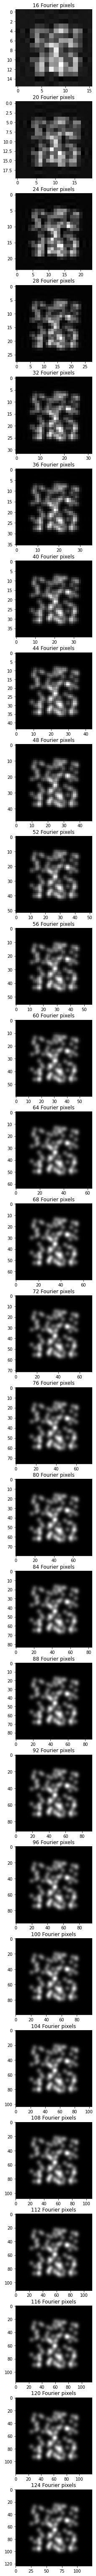

In [237]:
N_crops = [4*n for n in range(4, np.int32(N/4))]
fig,axes = plt.subplots(nrows=len(N_crops),figsize=(36, 4*len(N_crops)))

for idx, N_crop in enumerate(N_crops):
  s,e = N//2-N_crop//2, N//2+N_crop//2
  g_crop = fourier.do_ifft(g_f[s:e,s:e,s:e])
  axes[idx].imshow(g_crop.sum(-1),cmap='gray') ; axes[idx].set_title('%i pixels'%N_crop)
